<h1 align="center">Omnipresence ML Backend</h1>

<h3>Importing Required Libraries</h3>

In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt

<h3>Data Preprocessing</h3>

In [2]:
data_dir='Data/'
fpaths=[]
labels=[]
for filename in os.listdir(data_dir):
    if filename.startswith('positive'):
        labels.append(1)
        #For Scream
    elif filename.startswith('negative'):
        labels.append(0)
        #For NotScream
    fpaths.append(os.path.join(data_dir,filename))

print(f"N. files: {len(fpaths)}")
print(f"Labels: {labels[:]}")
                             

N. files: 121
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<h3>Data Augmentation</h3>

In [3]:
def augment_audio(audio, sample_rate):
    try:
        # Time-shifting
        shift = np.random.randint(sample_rate)
        augmented_audio = np.roll(audio, shift)
        
        # Adding noise
        noise = np.random.randn(len(audio))
        augmented_audio = augmented_audio + 0.005 * noise
        
        # Changing pitch
        pitch_factor = np.random.uniform(low=-5, high=5)
        augmented_audio = librosa.effects.pitch_shift(augmented_audio, sr=sample_rate, n_steps=pitch_factor)
        
        # Changing speed
        speed_factor = np.random.uniform(low=0.9, high=1.1)
        augmented_audio = librosa.effects.time_stretch(augmented_audio, rate=speed_factor)
        
        return augmented_audio
    except Exception as e:
        print(f"Error augmenting audio: {e}")
        return audio

# Apply augmentation to the audio files
augmented_audios = [augment_audio(librosa.load(file_path, sr=16000)[0], 16000) for file_path in fpaths]




<h3>Extracting features from Audio:</h3>

In [4]:
def extract_features_from_audio(audio, sample_rate=16000, max_pad_len=174):
    try:
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
        
        # Pad or truncate the MFCCs to ensure they have a consistent length
        if mfccs.shape[1] > max_pad_len:
            mfccs = mfccs[:, :max_pad_len]
        else:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
        # Return the MFCCs
        return mfccs
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

# Extract features for all augmented audios
augmented_features = [extract_features_from_audio(audio) for audio in augmented_audios]
augmented_features = [feature for feature in augmented_features if feature is not None]  # Remove any None values

# Convert to numpy array for machine learning
X = np.array(augmented_features)
y= np.array(labels)  # Ensure that this matches the length of X_augmented

print(f"Augmented feature shape: {X.shape}")
print(f"Labels shape: {y.shape}")



Augmented feature shape: (121, 20, 174)
Labels shape: (121,)


<h3>Defining the Model</h3>

In [5]:
X_reshaped = X.reshape(-1, 20, 174, 1)


def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(20, 174, 1)))  # Use Input layer as the first layer
    model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Choice('conv_1_kernel', values=[3,5]), 
                     activation='relu', 
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Choice('conv_2_kernel', values=[3,5]), 
                     activation='relu',
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model


<h3>Hyperparameter Tuning</h3>

In [6]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='audio_scream_detection'
)

# Print a summary of the search space
tuner.search_space_summary()

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
Optimal number of filters in the first conv layer: {best_hps.get('conv_1_filters')}
Optimal kernel size for the first conv layer: {best_hps.get('conv_1_kernel')}
Optimal dropout rate for the first dropout layer: {best_hps.get('dropout_1')}
Optimal number of filters in the second conv layer: {best_hps.get('conv_2_filters')}
Optimal kernel size for the second conv layer: {best_hps.get('conv_2_kernel')}
Optimal dropout rate for the second dropout layer: {best_hps.get('dropout_2')}
Optimal number of units in the dense layer: {best_hps.get('dense_units')}
Optimal dropout rate for the dense dropout layer: {best_hps.get('dropout_dense')}
Optimal learning rate for the optimizer: {best_hps.get('learning_rate')}
""")

Reloading Tuner from my_dir\audio_scream_detection\tuner0.json
Search space summary
Default search space size: 9
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout_dense (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_va

<h3>Split the Data</h3>

In [7]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (84, 20, 174, 1)
Validation data shape: (37, 20, 174, 1)


<h3>Training the model</h3>

In [8]:
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy}")


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.6010 - loss: 12.7491 - val_accuracy: 0.8108 - val_loss: 40.4229
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.8542 - loss: 3.2646 - val_accuracy: 0.8108 - val_loss: 9.8176
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.3942 - loss: 1.9149 - val_accuracy: 0.8108 - val_loss: 7.8707
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.8856 - loss: 0.2938 - val_accuracy: 0.8108 - val_loss: 8.7496
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8367 - loss: 0.5553 - val_accuracy: 0.8108 - val_loss: 7.7778
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.8484 - loss: 0.2867 - val_accuracy: 0.8108 - val_loss: 6.3803
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8562 - loss: 0.1945 - val_accuracy: 0.8108 - val_loss: 5.1189
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.8718 - loss: 0.1543 - val_accuracy: 0.8108 -

<h3>Visualization</h3>
 Plot training & validation accuracy values

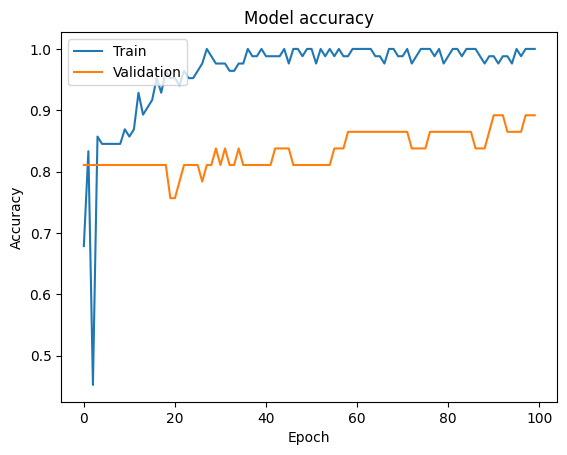

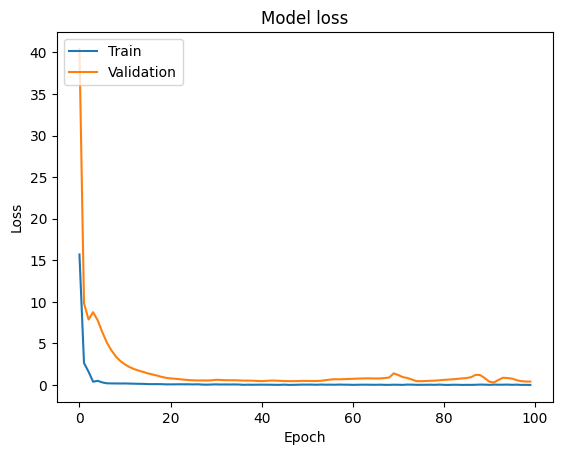

In [9]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


<h3>Data Preprocessing Steps for Input Audio:</h3>
<ol><li>The input audio must be preprocessed before to match the input shape of the model.</li>
<li>Additionaly, it's important to convert the input audio files in WAV format(Or FFmpeg supported formats) first.</li></ol>


In [10]:

def preprocess_audio(file_path, max_pad_len=174):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=16000)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
        
        # Pad or truncate the MFCCs to ensure they have a consistent length
        if mfccs.shape[1] > max_pad_len:
            mfccs = mfccs[:, :max_pad_len]
        else:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
        # Add an extra dimension to match the input shape of the model
        mfccs = mfccs.reshape(1, 20, max_pad_len, 1)
        
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Preprocess the audio file
audio_path = 'mixkit-fast-rocket-whoosh-1714.wav'
preprocessed_audio = preprocess_audio(audio_path)

# Make predictions
if preprocessed_audio is not None:
    prediction = model.predict(preprocessed_audio)
    # Convert the prediction to a label
    label = 'Scream' if prediction[0] > 0.5 else 'Non-Scream'
    print(f"Prediction: {label}")
else:
    print("Error in preprocessing the audio file.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Prediction: Non-Scream


<h3>Saving The Model</h3>
Saving model for Deployment

In [12]:
'''
import pickle

with open('Model.pkl', 'wb') as f:
    pickle.dump(model, f)'''